In [1]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/Cute_dog.jpg/1600px-Cute_dog.jpg?20140729055059'

In [2]:
import torch, os, math, gzip, pickle
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from pathlib import Path

from torch import tensor
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
from torch.utils.cpp_extension import load_inline

In [3]:
path_img = Path('puppy.jpg')
if not path_img.exists(): urlretrieve(url, path_img)

In [4]:
img = io.read_image('puppy.jpg')
print(img.shape)
img[:2,:3,:4]

torch.Size([3, 1066, 1600])


tensor([[[116, 118, 116, 112],
         [119, 128, 127, 113],
         [130, 126, 121, 114]],

        [[ 82,  84,  84,  80],
         [ 85,  96,  95,  82],
         [ 98,  94,  88,  83]]], dtype=torch.uint8)

In [5]:
def show_img(x, figsize=(4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

In [6]:
img2 = tvf.resize(img, 150, antialias=True)
ch,h,w = img2.shape
ch,h,w,h*w

(3, 150, 225, 33750)

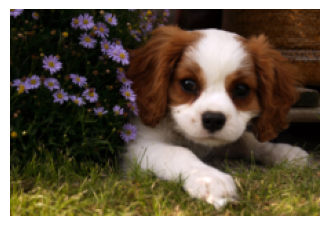

In [7]:
show_img(img2)

## rgb -> Grey

The image which is multidimenetional is represented in a flat struct in cuda or low level. Lets implement same approach.

In [8]:
img2.shape, img2.flatten().shape

(torch.Size([3, 150, 225]), torch.Size([101250]))

In [9]:
tmp = img2.flatten()

In [10]:
n = h * w

In [11]:
res = torch.empty(n, dtype=torch.uint8)
res.shape, res.dtype

(torch.Size([33750]), torch.uint8)

In [12]:
for i in range(n):
    res[i] = 0.2989*tmp[i] + 0.5870*tmp[i+n] + 0.1140*tmp[i+2*n]

In [13]:
res.shape

torch.Size([33750])

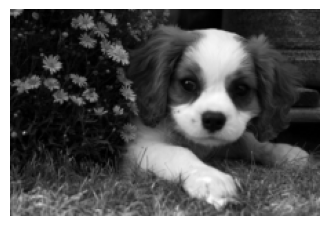

In [14]:
show_img(res.view(h, w), cmap='gray')

In [15]:
def rgb_grey(im):
  c, h, w = im.shape
  n = h * w # total no of pixel in output
  res = torch.empty(n, dtype=im.dtype, device=im.device)
  im = im.flatten()
  for i in range(n):
    res[i] = 0.2989*im[i] + 0.5870*im[n + i] + 0.1140*im[2 * n + i]

  return res.view(h,w)


In [16]:
%%timeit
t = rgb_grey(img2)

1.64 s ± 406 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


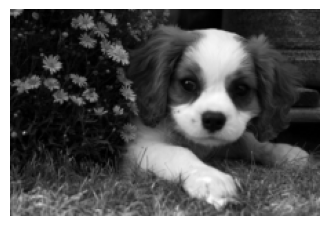

In [17]:
show_img(rgb_grey(img2), cmap='gray')

## CUDA setup

In [18]:
os.environ['CUDA_LAUNCH_BLOCKING']='1'
# Get the CUDA capability of the current device
if torch.cuda.is_available():
    major, minor = torch.cuda.get_device_capability()
    # Set the environment variable with the detected architecture
    os.environ['TORCH_CUDA_ARCH_LIST'] = f"{major}.{minor}"
    print(f"Setting TORCH_CUDA_ARCH_LIST to: {os.environ['TORCH_CUDA_ARCH_LIST']}")

Setting TORCH_CUDA_ARCH_LIST to: 7.5


In [19]:
%pip install -q wurlitzer ninja

In [20]:
%load_ext wurlitzer

In [21]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

In [22]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

In [36]:
cuda_src = cuda_begin + r'''
extern "C" __global__ void rgb2gray_kernel(
  const unsigned char *im,
  unsigned char * op, int h, int w)
  {
    int r = blockIdx.y * blockDim.y + threadIdx.y;
    int c = blockIdx.x * blockDim.x + threadIdx.x;

    if (r < h && c < w) {
    int idx = r * w + c;
    int n = h * w;

    op[idx] = 0.2989*im[idx] + 0.5870*im[n + idx] + 0.1140*im[2 * n + idx];
  }
}


torch::Tensor rgb2gray(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    torch::Tensor output = torch::empty({h,w}, input.options());
    dim3 tpb(32,32);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    rgb2gray_kernel<<<blocks, tpb>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), h, w);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
    }

'''

In [37]:
cpp_src = "torch::Tensor rgb2gray(torch::Tensor input);"
module = load_cuda(cuda_src, cpp_src, ['rgb2gray'], verbose=True)

Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
The input conditions for extension module inline_ext have changed. Bumping to version 2 and re-building as inline_ext_v2...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py311_cu124/inline_ext/build.ninja...
Building extension module inline_ext_v2...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext_v2 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.11/dist-packages/torch/include -isystem /usr/local/lib/python3.11/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.11/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.11/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /root/.cache/torch_extensions/py311_cu124/inline_ext/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext_v2 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.11/dist-packages/torch/i

Loading extension module inline_ext_v2...


In [38]:
dir(module)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'rgb2gray']

In [39]:
imgc = img.contiguous().cuda()

In [40]:
%%time
res = module.rgb2gray(imgc).cpu()
h,w = res.shape
h,w,h*w

CPU times: user 1.75 ms, sys: 0 ns, total: 1.75 ms
Wall time: 1.76 ms


(1066, 1600, 1705600)

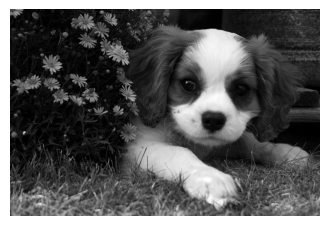

In [41]:
show_img(res, cmap='gray')

In [42]:
img2c = img2.contiguous().cuda()

In [43]:
%%time
res = module.rgb2gray(img2c).cpu()
h,w = res.shape
h,w,h*w

CPU times: user 418 µs, sys: 0 ns, total: 418 µs
Wall time: 428 µs


(150, 225, 33750)

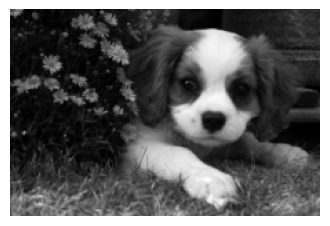

In [31]:
show_img(res, cmap='gray')